# Scalability

The solution and estimation of finite-horizon discrete choice dynamic programming model appears straightforward. However, it entails a considerable computational burden due to the well known curse of dimensionality (Bellman and Dreyfus, 1962). The figure below illustrates how the total number of states increases exponentially with each period using the first parametrization of Keane and Wolpin (1994).

In [1]:
%matplotlib agg
import datetime as dt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import FuncFormatter
from respy import get_example_model
from respy.python.shared.shared_constants import ROOT_DIR
from respy.python.solve.solve_auxiliary import pyth_create_state_space

In [2]:
plt.style.use(str(ROOT_DIR.parent / "docs" / "respy.mplstyle"))

In [3]:
options_spec, _ = get_example_model("kw_data_one")

num_types = 1
edu_starts = options_spec["edu_spec"]["start"]
edu_max = options_spec["edu_spec"]["max"]

number_of_states = [0]

for num_periods in range(5, 41, 5):
    states, _ = pyth_create_state_space(num_periods, num_types, edu_starts, edu_max)
    
    number_of_states.append(states.shape[0])

fig, ax = plt.subplots()

ax.plot(range(0, 41, 5), number_of_states)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))

ax.set_xlim(0, 40)
ax.set_ylim(0, number_of_states[-1])

ax.grid(True, which="major", axis="both", ls="--", lw=0.5)

ax.set_xlabel("Number of periods")
ax.set_ylabel("Number of states")

Text(0, 0.5, 'Number of states')

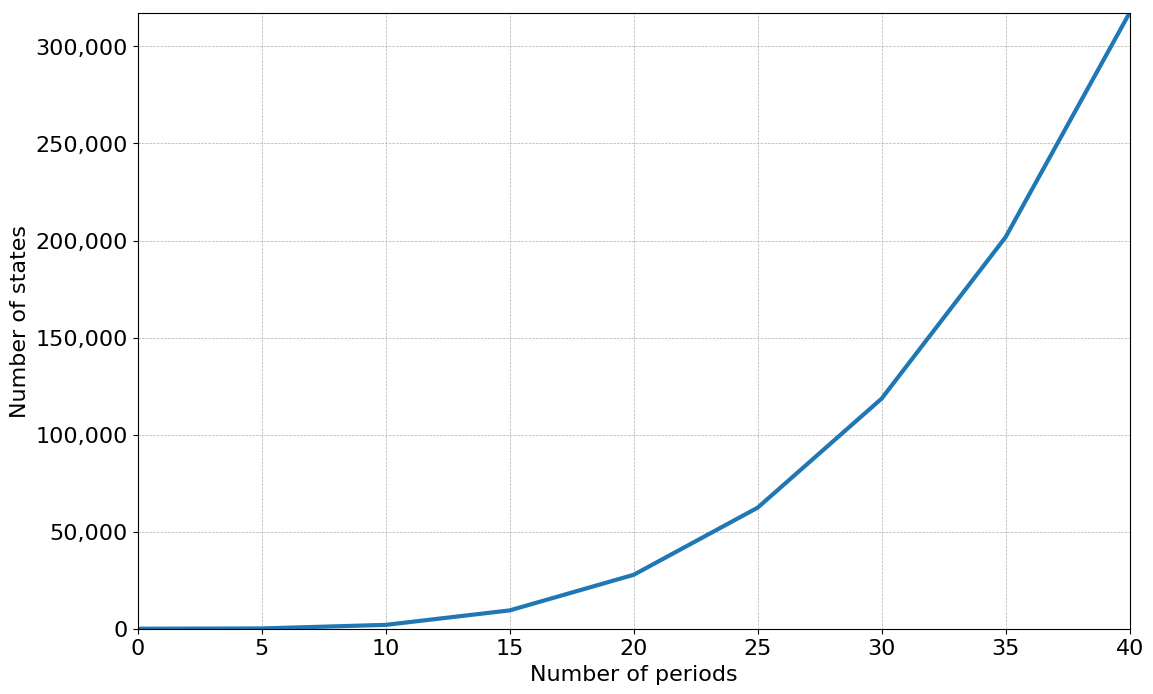

In [4]:
fig

During an estimation, thousands of different candidate parameterizations of the model are appraised with respect to the sample likelihood. Each time we need to evaluate the four-dimensional integral of $E\max$ at a total of 163,410 states. Thus, in addition to Python, we also maintain a scalar and parallel Fortran implementation. We parallelize the workload using the master-slave paradigm. We assign each slave a subset of states to evaluate the $E\max$ and a subset of agents to simulate their choice probabilities. Below, we show the total computation time required for 1,000 evaluations of the criterion function as we increase the number of slave processors to ten. Judging against the linear benchmark, the code scales well over this range.

In [5]:
def string_to_seconds(x):
    x = x.split(":")
    return dt.timedelta(
        hours=int(x[0]), minutes=int(x[1]), seconds=int(x[2])
    ).total_seconds()


fortran = ["01:27:51", "00:45:16", "00:24:08", "00:17:52", "00:13:55", "00:11:52"]
fortran = np.array([string_to_seconds(i) for i in fortran])

python = ["1:35:36", "0:55:52", "0:36:48", "0:32:47", "0:28:11", "0:27:57"]
python = np.array([string_to_seconds(i) for i in python])

cores = np.array([1, 2, 4, 6, 8, 10])

fortran_benchmark = np.append(fortran[0], fortran[:-1] * cores[:-1] / cores[1:])
python_benchmark = np.append(python[0], python[:-1] * cores[:-1] / cores[1:])


def format_time(x, pos=None):
    return str(dt.timedelta(seconds=int(x)))


fig, ax = plt.subplots()

ax.plot(cores, fortran, label="Fortran")
ax.plot(cores, fortran_benchmark, c="C0", ls="--")

ax.plot(cores, python, label="Python")
ax.plot(cores, python_benchmark, c="C1", ls="--")

ax.set_xticks([1, 2, 4, 6, 8, 10])
ax.set_yticks([i * 900 for i in range(1, 8)])

ax.set_xlim(1, 10)
ax.yaxis.set_major_formatter(FuncFormatter(format_time))

ax.grid(True, which="major", axis="both", ls="--", lw=0.5)

ax.set_xlabel("Number of threads")
ax.set_ylabel("Elapsed time")

handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], ls="--", c="grey"))
labels.append("Linear Benchmark")
ax.legend(handles=handles, labels=labels)

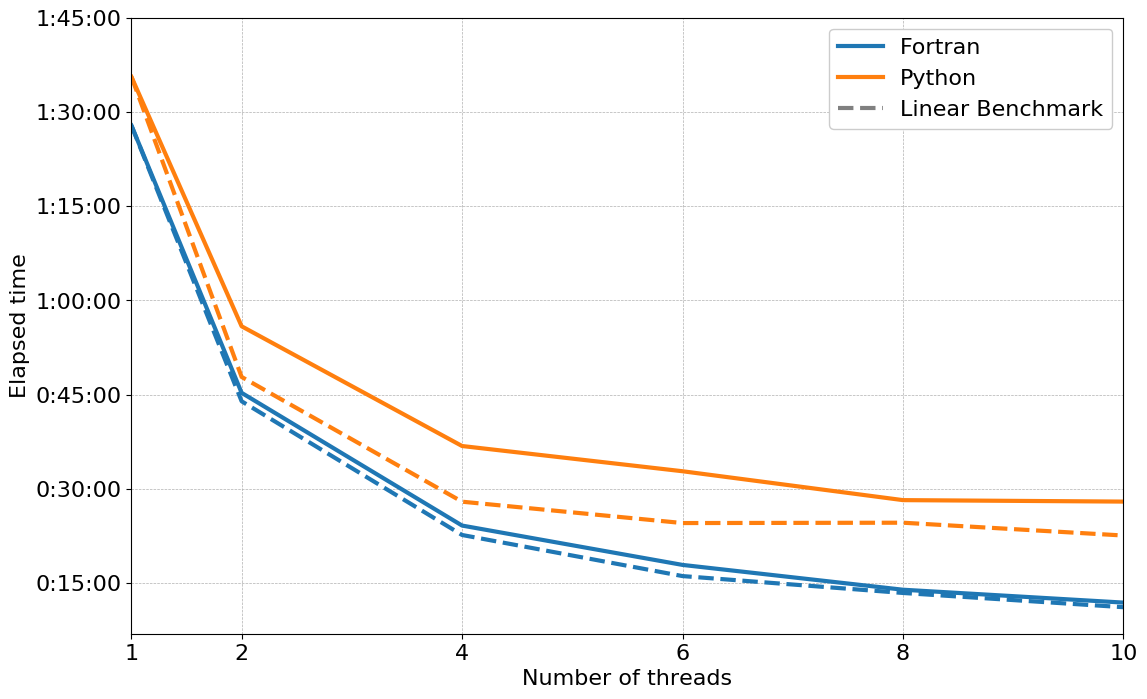

In [6]:
fig

Adding even more processors, however, does not lead to any further improvements, it even increases the computational time. The main reason is the time spend on the synchronization of $E\max$ across all processes each period. Even though each slave is only working on a subset of states each period, they need to access all previous $E\max$ results during the backward induction procedure.

For more details, see the script [online](https://github.com/OpenSourceEconomics/respy/blob/master/development/documentation/scalability/run_scalability.py) and the [logfile](https://github.com/OpenSourceEconomics/respy/blob/master/doc/results/scalability.respy.info).
